# AMES Linear Predictive Modelling

In [3]:
%load_ext autoreload  
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from models import load_ames_nei, load_ames, data_encoding, splitter, linear, encod_linear, split_linear 

import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
if not os.path.exists("images"): 
    os.mkdir("images")

<p><a name="top"></a></p>

Objective: Use AMES Housing Dataset to model SalePrice using Machine Learning Methods. Models used: Linear Regression, Lasso, LassoCV, Ridge, ElasticNet. 

Background Info from KAGGLE:
 - [Column Definitions](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
 - [Column Variables](https://www.kaggle.com/datasets/ahmedmohameddawoud/ames-housing-data)

Contents:
 - <a href="#MLR">LinearRegression</a><br>
 - <a href="#Pen">Penalization</a><br>
     - <a href="#LASSO">Lasso</a><br>
     - <a href="#RIDGE">Ridge</a><br>
     - <a href="#ELASTIC">Elastic Net</a><br>
     - <a href="#LASSOCV">LassoCV</a><br>
 - <a href="#nei">Feature engineering: Neighborhoods Quantiles</a><br>
 - <a href="#sum">Summary and Interperetation</a><br>
 
     

In [5]:
#Load data

housing_d = load_ames_nei()
housing_X = housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long'])
housing_y = housing_d[['SalePrice']]

In [4]:
housing_X.head(2)
# housing_X.shape

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,date,rate,remodeled,Nei_quant
0,856,30,RL,0,7890,Pave,Reg,Lvl,AllPub,Corner,...,N,0,3,2010,WD,Normal,2010-03-01,4.99,1,1 - Low
1,1049,120,RL,42,4235,Pave,Reg,Lvl,AllPub,Inside,...,N,0,2,2009,WD,Normal,2009-02-01,5.07,0,1 - Low


In [6]:
housing_X = housing_X.drop(columns = 'date')

In [7]:
# List of num and categorical features. Can changes as needed. 

categorical = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
              'Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
              'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
              'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
              'Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',
               'PoolQC','Fence','MiscFeature','SaleType','SaleCondition',
               'Nei_quant','remodeled','MoSold',]
    
continuous = ['SalePrice','GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','rate','OverallQual','YrSold','OverallCond',]

<p><a name="MLR"></a></p>

### Linear Regression Models <a href="#top">[top]</a><br>


Overall strategy:
1. <a href="#Sat">Begin with saturated model.</a>
2. <a href="#Coef">Assess coefficients.</a><br>
3. <a href="#Fea">Select Features.</a><br>
4. <a href="#Imp">Iterate on Model to improve scoring.</a><br>

In [8]:
#Y transfomration, box cox
from scipy.stats import boxcox 
housing_d['SalePrice_box'], lambda_value = boxcox(housing_d['SalePrice'])
housing_d = housing_d.drop(columns = 'date')

<p><a name="Sat"></a></p>

#### Saturated Model <a href="#con">[top]</a><br>

In [9]:
#SATURATED
linear_tests = ['No log, Norm','Log, Norm','Box, Norm','No log, SS', 'Log, SS','Box, SS']
pd.DataFrame([linear(housing_X, housing_y, log ='no', cont_trans = 'n')[1], linear(housing_X, housing_y, log ='yes', cont_trans = 'n')[1],
              linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']], log ='no', cont_trans = 'n')[1],
             linear(housing_X, housing_y, log ='no', cont_trans = 'ss')[1],linear(housing_X, housing_y, log ='yes', cont_trans = 'ss')[1],
             linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']], log ='no', cont_trans = 'ss')[1]]
            , index = linear_tests)#.style.apply(lambda x: ['background-color: yellow' if x.name == 'Log, Norm' else '' for i in x], axis=1)

,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
"No log, Norm",8.790000e-01,7.250000e-01,0.909,7.710902e+08,1.894374e+04,2.776851e+04
"Log, Norm",9.100000e-01,7.960000e-01,0.934,1.400000e-02,8.400000e-02,1.180000e-01
"Box, Norm",9.090000e-01,7.930000e-01,0.933,5.000000e-03,4.900000e-02,7.100000e-02
"No log, SS",-1.571126e+20,-3.568201e+20,0.940,1.002471e+30,7.049914e+13,1.001235e+15
"Log, SS",-5.726598e+20,-1.300574e+21,0.943,8.915567e+19,6.648482e+08,9.442228e+09
"Box, SS",-6.002868e+20,-1.363318e+21,0.941,3.214125e+19,3.991897e+08,5.669325e+09


Comparing the x transformations: Normalizer vs StandardScaler (SS):
- The SS is fits the trainign data better, but is not extremely overfitted. The test R squared is a negative value, near zero.
- Conversely the Normalizer shows slightly lower training scores, but higher test scores.

r2 vs adj r2:
- Although the r2 values for the Normalized transforms exceed 90%, the adjusted r2 are lower (70-80%) due to number parameters. Therefore, we need to reduce the number of features to (1) increase adj r2 performanace and decreaes potential multicolinearity. The increase of multicolinearlity decreases model stability.

Comparing the y transformations Log vs No Log:
- In the visual EDA, we saw that the SalePrice fans out and does not follow a linear behavior. By taking the natural log of SalePrice, the dependent follows a more linear patter. In addition the histograom is skewed to the left. By transforming, we coerced the dependent to variable to be more Gaussian. 
- There is a third option for transformation: box cox transformation. After applying the bos cox module, there is not a substncial improvement. 


<p><a name="Coef"></a></p>

#### Coefficients <a href="#con">[top]</a><br>

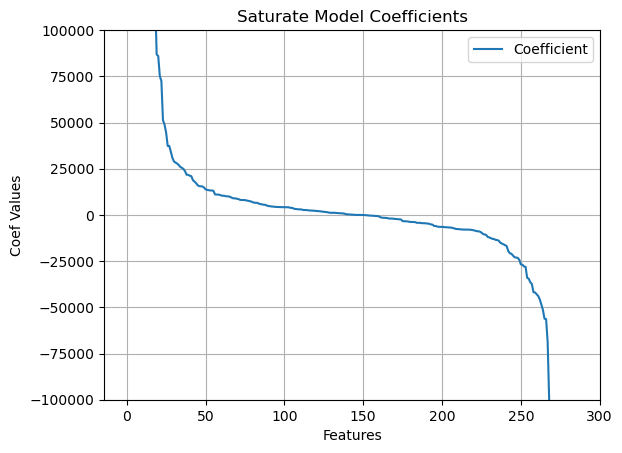

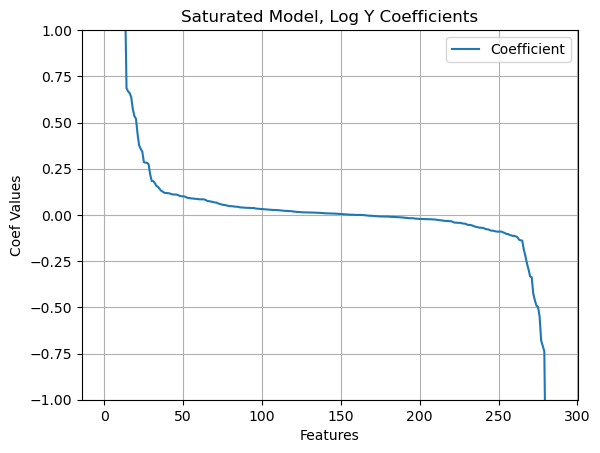

In [21]:
#Plots of log and no log models. 

#Saturated Model
linear(housing_X, housing_y, log ='no', cont_trans = 'n', model = 'linear')[2].reset_index().plot( y = 'Coefficient',
                                                                                    ylabel = 'Coef Values',
                                                                                   title = 'Saturate Model Coefficients',
                                                                                    grid = True, xlabel = 'Features',
                                                                                    ylim = [-100000,100000]
                                                                                   )
# Save the figure
fig = plt.gcf()
fig.savefig('images/MLR_Sat_Coef.png')

#Saturated Model, LogY
linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].reset_index().plot( y = 'Coefficient',
                                                                                   title = 'Saturated Model, Log Y Coefficients',
                                                                                                   ylabel = 'Coef Values',
                                                                                     grid = True, xlabel = 'Features',
                                                                                    ylim = [-1,1]
                                                                                    )
linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].iloc[150,]
fig = plt.gcf()
fig.savefig('images/MLR_Sat_Coef_Log.png')

The majority of these features do not have a large impact on the outcome of the prediction. 
There are a select number of coef on either end of the spectrum that are significant. 
Let's take the abs value of the head and tail and sort the top 15. 

In [38]:
# lowest 15 coefficients
linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).tail(15)

,Feature,Coefficient
105,Condition2_PosN,-0.426458
234,GarageQual_Gd,-0.461923
237,GarageQual_TA,-0.491129
14,LowQualFinSF,-0.497909
233,GarageQual_Fa,-0.549103
23,GarageYrBlt,-0.679946
236,GarageQual_Po,-0.710242
2,LotArea,-0.738375
34,rate,-1.461612
21,TotRmsAbvGrd,-3.752997


In [40]:
# top 15 coefficients
linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(15)

,Feature,Coefficient
4,OverallCond,357.815484
3,OverallQual,345.019851
24,GarageCars,217.789213
22,Fireplaces,145.677829
17,FullBath,82.423131
15,BsmtFullBath,41.680080
18,HalfBath,31.186662
5,YearBuilt,14.321904
6,YearRemodAdd,2.074637
1,LotFrontage,1.637876


In [77]:
#combination of head and tail of coefficients. 
combo = pd.concat([linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(15),linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).tail(15)])
combo['abs'] = abs(combo['Coefficient'])
combo.sort_values(by = 'abs', ascending = False).head(20)

,Feature,Coefficient,abs
20,KitchenAbvGr,-445.703026,445.703026
4,OverallCond,357.815484,357.815484
3,OverallQual,345.019851,345.019851
24,GarageCars,217.789213,217.789213
16,BsmtHalfBath,-182.028548,182.028548
22,Fireplaces,145.677829,145.677829
17,FullBath,82.423131,82.423131
19,BedroomAbvGr,-63.970786,63.970786
15,BsmtFullBath,41.680080,41.680080
18,HalfBath,31.186662,31.186662


,Feature,r2_n,Adjusted r2_n,train r2_n,MSE_n,Abs Error_n,RMSE_n,r2_ss,Adjusted r2_ss,train r2_ss,MSE_ss,Abs Error_ss,RMSE_ss
0,OverallCond,-0.001,-0.001,0.000,0.156,skip,0.395,-0.003,-0.003,0.005,0.156,skip,0.395
1,OverallQual,0.282,0.281,0.405,0.112,skip,0.335,0.655,0.654,0.669,0.054,skip,0.232
2,GarageCars,0.337,0.334,0.423,0.103,skip,0.321,0.718,0.717,0.729,0.044,skip,0.210
3,Fireplaces,0.422,0.419,0.471,0.090,skip,0.300,0.752,0.751,0.757,0.039,skip,0.197
4,FullBath,0.427,0.422,0.471,0.089,skip,0.298,0.779,0.777,0.772,0.034,skip,0.184
5,BsmtFullBath,0.439,0.433,0.481,0.087,skip,0.295,0.802,0.800,0.791,0.031,skip,0.176
6,HalfBath,0.447,0.440,0.489,0.086,skip,0.293,0.808,0.806,0.796,0.030,skip,0.173
7,YearBuilt,0.796,0.793,0.786,0.032,skip,0.179,0.819,0.816,0.807,0.028,skip,0.167
8,YearRemodAdd,0.804,0.801,0.791,0.031,skip,0.176,0.819,0.816,0.808,0.028,skip,0.167
9,LotFrontage,0.812,0.809,0.795,0.029,skip,0.170,0.828,0.825,0.813,0.027,skip,0.164


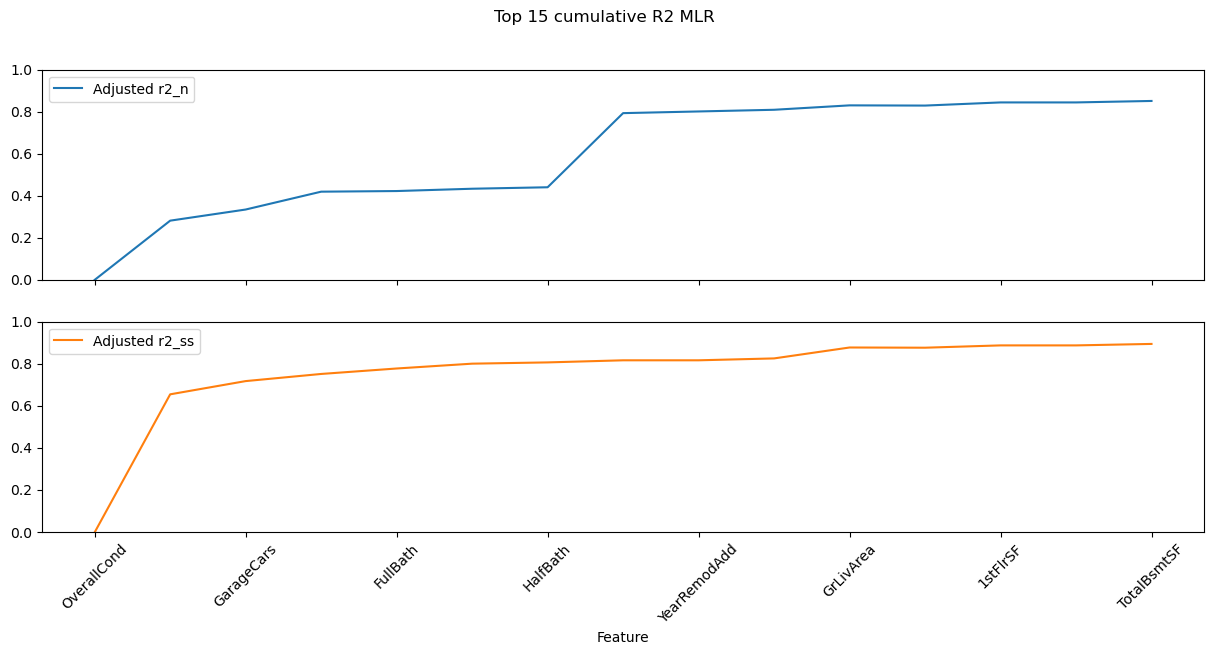

In [43]:
#Top 15 features, Normalizer vs SS

#Top 15 features of MLR (taken from Normalized Saturated MLR)
top_15 = linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(15)
top_15['Coef %'] = top_15.Coefficient/np.sum(top_15.Coefficient)

#pulling an encoded dataset and saving 
X1 = data_encoding(housing_X, housing_y, log = 'yes')[0]
y1 = data_encoding(housing_X, housing_y, log = 'yes')[1]

top_15_cum_n = []
for i in range(1,16):
    top_15_cum_n.append(split_linear(X1[top_15.head(i).Feature], y1['SalePrice'], cont_trans = 'n', model = 'linear')[1])
             
top_15_cum_ss = []
for i in range(1,16):
    top_15_cum_ss.append(split_linear(X1[top_15.head(i).Feature], y1['SalePrice'], cont_trans = 'ss', model = 'linear')[1])

#MLR by adding in features one at a time. Each row's model includes the feature and all of the others of index before it. 
#row 14 include all top 15 features.

#Plot
pd.DataFrame(top_15_cum_n, index = top_15.Feature).reset_index().merge(
    pd.DataFrame(top_15_cum_ss, index = top_15.Feature).reset_index(), how = 'left', on = 'Feature', suffixes=('_n', '_ss')).plot.line(
    x = 'Feature',y = ['Adjusted r2_n', 'Adjusted r2_ss'], subplots = True, title = 'Top 15 cumulative R2 MLR', 
    ylim = [0,1], figsize = (15,6), sharex = True, rot = 45)

#Save
fig = plt.gcf()
fig.savefig('images/MLR_Cum15_Coef_Log.png')

#Data
pd.DataFrame(top_15_cum_n, index = top_15.Feature).reset_index().merge(
    pd.DataFrame(top_15_cum_ss, index = top_15.Feature).reset_index(), how = 'left', on = 'Feature', suffixes=('_n', '_ss'))


In [79]:
#Model for two abs 20

abs_top20 = []
for i in range(1,21):
    abs_top20.append(split_linear(
        X1[combo.sort_values(by = 'abs', ascending = False).head(20).head(i).Feature], 
        y1['SalePrice'], cont_trans = 'ss', model = 'linear')[1])
pd.DataFrame(abs_top20, index = combo.sort_values(by = 'abs', ascending = False).head(20).Feature)

,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
Feature,,,,,,
KitchenAbvGr,-0.002,-0.002,0.020,0.156,skip,0.395
OverallCond,-0.006,-0.008,0.027,0.157,skip,0.396
OverallQual,0.654,0.653,0.669,0.054,skip,0.232
GarageCars,0.716,0.714,0.730,0.044,skip,0.210
BsmtHalfBath,0.716,0.714,0.730,0.044,skip,0.210
Fireplaces,0.750,0.748,0.757,0.039,skip,0.197
FullBath,0.775,0.772,0.775,0.035,skip,0.187
BedroomAbvGr,0.779,0.776,0.781,0.034,skip,0.184
BsmtFullBath,0.808,0.805,0.803,0.030,skip,0.173


There are many features may be multicolinear. To understand which ones, let's looks at a quick correlation map.

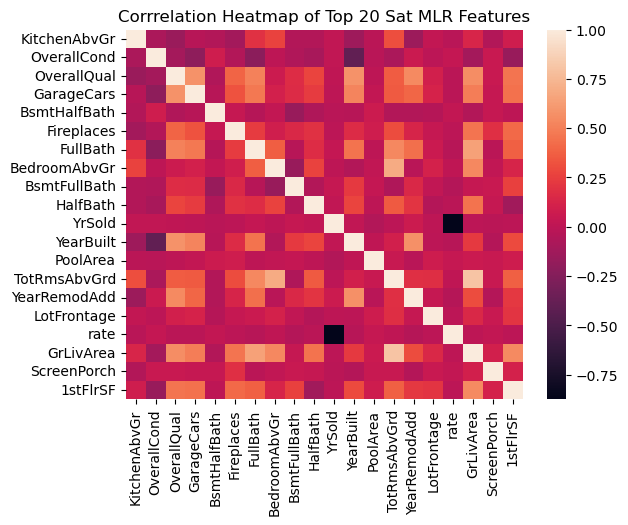

In [153]:
#Top 20 Features Heatmap

sns.heatmap(housing_d[combo.sort_values(by = 'abs', ascending = False).head(20).Feature].corr())
plt.title('Corrrelation Heatmap of Top 20 Sat MLR Features')
plt.savefig('images/top20_heatmap.png')

The highest adjusted r2 is at top 15 features with KitchenAbvGr, BedroomAbvGr, BsmtHalfBath, YrSold for the SS MLR Model with Log Y Transformations. 
0.896 or 89.6%

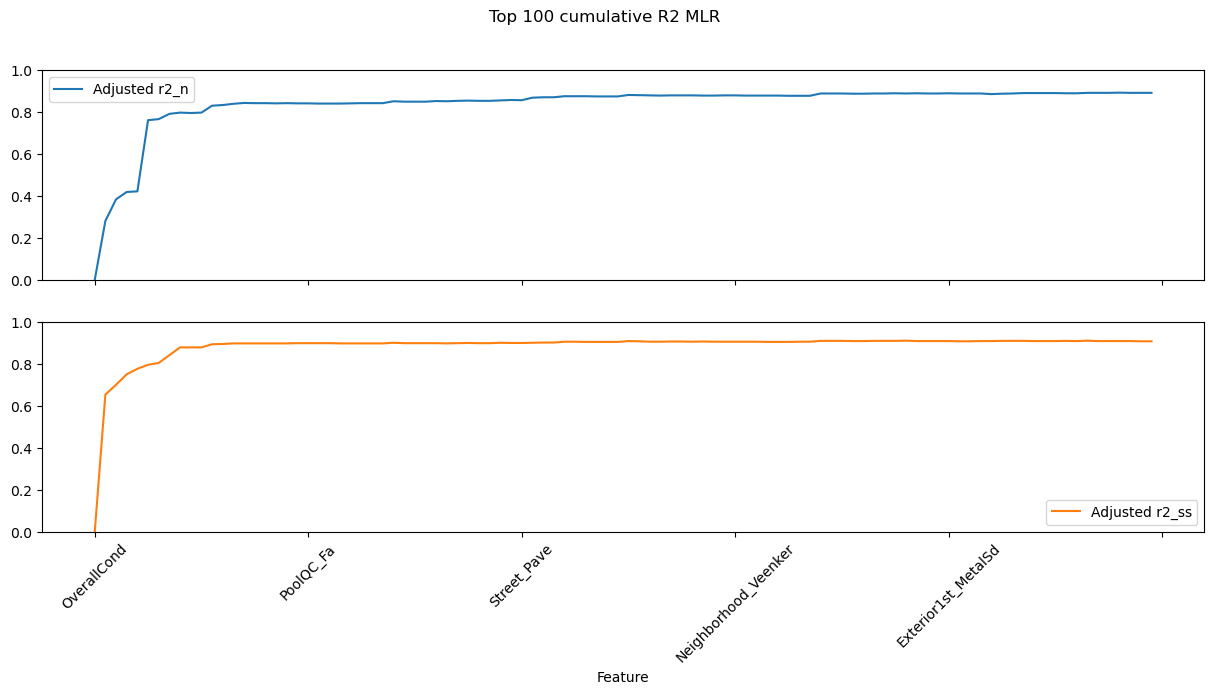

In [11]:
#Top 100 features, Normalizer vs SS

top_100_cum_n = []
for i in range(1,101):
    top_100_cum_n.append(split_linear(X1[linear(housing_X, housing_y, log ='no', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(100).head(i).Feature], y1['SalePrice'], cont_trans = 'n', model = 'linear')[1])
             
top_100_cum_ss = []
for i in range(1,101):
    top_100_cum_ss.append(split_linear(X1[linear(housing_X, housing_y, log ='no', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(100).head(i).Feature], y1['SalePrice'], cont_trans = 'ss', model = 'linear')[1])

top_100_sat = linear(housing_X, housing_y, log ='no', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(100)

pd.DataFrame(top_100_cum_n, index = top_100_sat.Feature).reset_index().merge(
    pd.DataFrame(top_100_cum_ss, index = top_100_sat.Feature).reset_index(), how = 'left', on = 'Feature', suffixes=('_n', '_ss')).plot.line(
    x = 'Feature',y = ['Adjusted r2_n', 'Adjusted r2_ss'], subplots = True, title = 'Top 100 cumulative R2 MLR', 
    ylim = [0,1], figsize = (15,6), sharex = True, rot = 45)

# Save the figure
fig = plt.gcf()
fig.savefig('images/MLR_cum100.png')

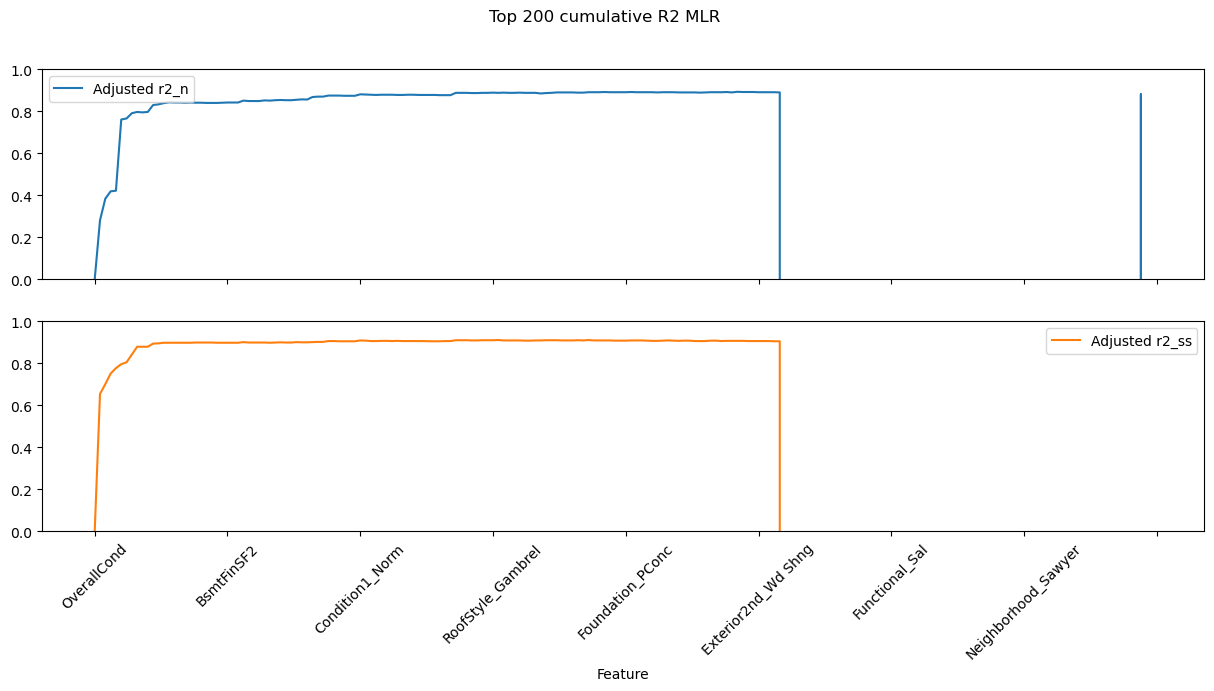

In [12]:
#Top 200 features, Normalizer vs SS

top_200_sat = linear(housing_X, housing_y, log ='no', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(200)

top_200_cum_n = []
for i in range(1,201):
    top_200_cum_n.append(split_linear(X1[top_200_sat.head(i).Feature], y1['SalePrice'], cont_trans = 'n', model = 'linear')[1])
             
top_200_cum_ss = []
for i in range(1,201):
    top_200_cum_ss.append(split_linear(X1[top_200_sat.head(i).Feature], y1['SalePrice'], cont_trans = 'ss', model = 'linear')[1])

pd.DataFrame(top_200_cum_n, index = top_200_sat.Feature).reset_index().merge(
    pd.DataFrame(top_200_cum_ss, index = top_200_sat.Feature).reset_index(), how = 'left', on = 'Feature', suffixes=('_n', '_ss')).plot.line(
    x = 'Feature',y = ['Adjusted r2_n', 'Adjusted r2_ss'], subplots = True, title = 'Top 200 cumulative R2 MLR', 
    ylim = [0,1], figsize = (15,6), sharex = True, rot = 45)

# Save the figure
fig = plt.gcf()
fig.savefig('images/MLR_cum200.png')

- The standard scalar works better for fewer features. 
- Relative improvement of adjusted r squared drops off as features are added. This could introduce instability as we can encounter feature feature interaction.
- In fact, as the number of indenpenets exceed 200, adjusted r squared becomes unpredictable, reflective of an unstable model.

The goal is to minimize number of independents, while maximizing adjusted r squared. Although adj r2 for the ss model does not peak until 100 features, it begins to level out at 8 features. It takes the addition of 90 more features to increase adj by 5%.

Find the top 8 - 12 features that maximize adj. We can do this by (1) reducing multi-colinearity and (2) testing permutations of a relatively small sample. 

<p><a name="Fea"></a></p>

#### Revisiting the Top 15 features <a href="#con">[top]</a><br>

,Feature,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE,Coefficient,Coef %
0,1stFlrSF,0.750,0.743,0.788,35890.840,skip,189.449,1.260695,0.001012
1,GrLivArea,0.720,0.713,0.745,61153.163,skip,247.292,1.334700,0.001072
2,YearBuilt,0.647,0.638,0.620,334.642,skip,18.293,14.321904,0.011500
3,TotalBsmtSF,0.646,0.637,0.687,64933.347,skip,254.820,0.685523,0.000550
4,OverallQual,0.498,0.485,0.523,0.880,skip,0.938,345.019851,0.277034
5,HalfBath,0.476,0.462,0.500,0.131,skip,0.362,31.186662,0.025041
6,FullBath,0.454,0.440,0.559,0.153,skip,0.391,82.423131,0.066182
7,GarageCars,0.409,0.394,0.439,0.337,skip,0.581,217.789213,0.174874
8,YearRemodAdd,0.397,0.381,0.379,256.461,skip,16.014,2.074637,0.001666
9,Fireplaces,0.316,0.298,0.297,0.274,skip,0.523,145.677829,0.116972


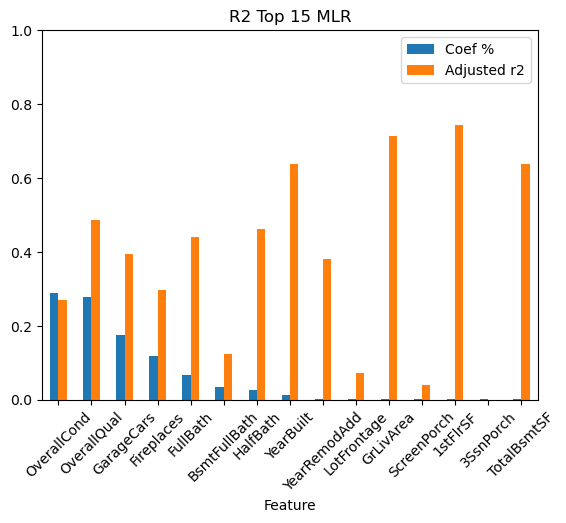

In [13]:
# Testing Top 15 for multicolinearity. 

#Top 15 features of MLR (taken from Normalized Saturated MLR)
top_15 = linear(housing_X, housing_y, log ='yes', cont_trans = 'n', model = 'linear')[2].sort_values(
        by='Coefficient', ascending=False).head(15)
top_15['Coef %'] = top_15.Coefficient/np.sum(top_15.Coefficient)

#pulling an encoded dataset and saving 
X1 = data_encoding(housing_X, housing_y, log = 'yes')[0]
y1 = data_encoding(housing_X, housing_y, log = 'yes')[1]
num1 = list(top_15.Feature[~top_15.Feature.str.contains('_')])

#Looping to get extract r2 and put in df. 
top_15_r2 = []
for i in top_15.Feature:
    top_15_r2.append(encod_linear(X1[top_15.Feature], i, cont_trans = 'n', model = 'linear')[1])

#Plot 
pd.DataFrame(top_15_r2, index = top_15.Feature).reset_index().merge(top_15,how = 'left', on = 'Feature').plot.bar(
    x='Feature', y=['Coef %','Adjusted r2'], ylim = [0,1], title = 'R2 Top 15 MLR', rot = 45)

# Save the figure
fig = plt.gcf()
fig.savefig('images/MLR_top_15_r2.png')

#df
pd.DataFrame(top_15_r2, index = top_15.Feature).reset_index().merge(top_15,how = 'left', on = 'Feature').sort_values(
    by = 'Adjusted r2', ascending = False).reset_index().drop(columns = 'index')

Remarks

- Features that measure square footage have higher r2 and show more multicolinearity relative to one another. It would be better to remove some as this may not make the model unstable.

- Bathroom features are showing higher multicolinrarity, particulary 'HalfBath'. 

- The importance of fireplaces, garagecars, and fullbath are noteable here as they are reflective of the quality use of square footage. As we evaluating the log model, when there are 0 fireplaces or 0 car garages, we see no impact on the model. However, by having one or two, the value of the house goes up tremendously.
  
    - It is more than just having these status symbols, as one can build a room with three fireplaces. It is the context around these status symbols - having multiple cars, having multiple living rooms or places to gather, having larger families or the desire to have multiple bathrooms.
 
How important are these features? What dould happen if we just removed some or all? Let's run MLR and add in a feature at a time starting with the highest ranked feature in terms of coefficients. 

<p><a name="Impr"></a></p>

#### Stripping Features <a href="#con">[top]</a><br>

A manual sort of Recursive Feature Elimination.

In [14]:
#Stripping features and adding them back in in combinations

#Isolating square foot related features, and fireplaces to investigate
top_15_sizerel = list(top_15.Feature[top_15.Feature.str.contains('SF')])+['GrLivArea'] + ['Fireplaces'] + ['HalfBath']
from itertools import combinations

#Makign unique combinations of stripped features
combos = []
for i in range(1,5):
    for x in list(combinations(top_15_sizerel,i)):
        combos.append(list(x))
combos.append([])
combos

[['1stFlrSF'],
 ['TotalBsmtSF'],
 ['GrLivArea'],
 ['Fireplaces'],
 ['HalfBath'],
 ['1stFlrSF', 'TotalBsmtSF'],
 ['1stFlrSF', 'GrLivArea'],
 ['1stFlrSF', 'Fireplaces'],
 ['1stFlrSF', 'HalfBath'],
 ['TotalBsmtSF', 'GrLivArea'],
 ['TotalBsmtSF', 'Fireplaces'],
 ['TotalBsmtSF', 'HalfBath'],
 ['GrLivArea', 'Fireplaces'],
 ['GrLivArea', 'HalfBath'],
 ['Fireplaces', 'HalfBath'],
 ['1stFlrSF', 'TotalBsmtSF', 'GrLivArea'],
 ['1stFlrSF', 'TotalBsmtSF', 'Fireplaces'],
 ['1stFlrSF', 'TotalBsmtSF', 'HalfBath'],
 ['1stFlrSF', 'GrLivArea', 'Fireplaces'],
 ['1stFlrSF', 'GrLivArea', 'HalfBath'],
 ['1stFlrSF', 'Fireplaces', 'HalfBath'],
 ['TotalBsmtSF', 'GrLivArea', 'Fireplaces'],
 ['TotalBsmtSF', 'GrLivArea', 'HalfBath'],
 ['TotalBsmtSF', 'Fireplaces', 'HalfBath'],
 ['GrLivArea', 'Fireplaces', 'HalfBath'],
 ['1stFlrSF', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces'],
 ['1stFlrSF', 'TotalBsmtSF', 'GrLivArea', 'HalfBath'],
 ['1stFlrSF', 'TotalBsmtSF', 'Fireplaces', 'HalfBath'],
 ['1stFlrSF', 'GrLivArea', 'Fir

In [15]:
#Running MLR on stripped model with dropped features TOP 15 adj r2 is 89.4%

SF_cut = []
for i in combos:
    SF_cut.append(split_linear(X1[top_15.Feature].drop(columns = i), 
                 y1['SalePrice'], cont_trans = 'ss', model = 'linear')[1])
pd.DataFrame(SF_cut).merge(pd.DataFrame(enumerate(combos)), how = 'left', left_index = True, right_index = True).sort_values(
    by = 'Adjusted r2', ascending = False).rename(columns = {1:'Dropped Features'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 11 else '' for i in x], axis=1)


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE,0,Dropped Features
30,0.897000,0.894000,0.885000,0.016000,skip,0.126000,30,[]
4,0.897000,0.894000,0.885000,0.016000,skip,0.126000,4,['HalfBath']
8,0.896000,0.893000,0.885000,0.016000,skip,0.126000,8,"['1stFlrSF', 'HalfBath']"
0,0.896000,0.893000,0.885000,0.016000,skip,0.126000,0,['1stFlrSF']
3,0.890000,0.887000,0.880000,0.017000,skip,0.130000,3,['Fireplaces']
14,0.890000,0.887000,0.880000,0.017000,skip,0.130000,14,"['Fireplaces', 'HalfBath']"
11,0.890000,0.887000,0.879000,0.017000,skip,0.130000,11,"['TotalBsmtSF', 'HalfBath']"
1,0.890000,0.887000,0.879000,0.017000,skip,0.130000,1,['TotalBsmtSF']
20,0.888000,0.886000,0.879000,0.017000,skip,0.130000,20,"['1stFlrSF', 'Fireplaces', 'HalfBath']"
7,0.888000,0.885000,0.879000,0.017000,skip,0.130000,7,"['1stFlrSF', 'Fireplaces']"


Let's revisit the definitions

- TotalBsmtSF: Total square feet of basement area
- GrLivArea: Above grade (ground) living area square feet
- 1stFlrSF: First Floor square feet
- Fireplaces: Number of fireplaces

Some Findings:

- GrLivArea is most important as adjusted r2 decreases by 2.1% when excluded.
- TotalBsmtSF is second in importance as adjusted r2 decreases by .7% when excluded.
- 1stFlrSF is least important, as adjusted r2 decreases by .1% when excluded.
- Fireplaces are more relevant to the accuracy of this model than TotalBsmtSF or 1stFlrSF
- HalfBath should be eliminated. 

This analysis shows that removing all the features will decrease the model acurracy by 10%, but including just one could improve that score by 7% (index 14 vs 11). These means we need SOME indicator of square footage. GrLivArea is the most direct, but it is costly to calculate. Also, in some cases difficult to define. Conversely fireplaces are very easy to count and define. In a pinch, they could be very easy to use. 

In terms of data collection, would it be easier to build a model based on simple, easy to calculate features? fireplaces and bathrooms? Let's see...

In [16]:
#Model with easy to determine values or subjective features. Add one 'hard' feaure and see how adj r2 changes. 

#Define lists
easy_counters = ['GarageCars','Fireplaces','FullBath','BsmtFullBath','YearBuilt','remodeled']
select_one = ['LotFrontage','GrLivArea', 'ScreenPorch', '1stFlrSF', '3SsnPorch', 'TotalBsmtSF','OverallCond',
                'OverallQual']

#Smaller df
housing_X_1 = housing_X[easy_counters]

#Loop to create dataframe
results = []
for i in select_one:
    results.append(linear(pd.concat([housing_X_1,housing_X[i]], axis = 1), housing_y, log = 'yes', cont_trans = 'ss')[1])
results.append(linear(housing_X_1, housing_y, log = 'yes', cont_trans = 'ss')[1])

#All Features
print(linear(housing_X_1, housing_y, log = 'yes', cont_trans = 'ss')[2])

#Df with one of the select_one features added in
pd.DataFrame(results, index = select_one+['null'])


        Feature  Coefficient
0    GarageCars     0.118201
4     YearBuilt     0.109885
1    Fireplaces     0.101523
2      FullBath     0.090684
3  BsmtFullBath     0.051674
5   remodeled_1     0.032382


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
LotFrontage,0.707,0.704,0.684,0.046,0.164,0.214
GrLivArea,0.786,0.783,0.781,0.033,0.135,0.182
ScreenPorch,0.698,0.694,0.682,0.047,0.166,0.217
1stFlrSF,0.742,0.739,0.723,0.040,0.153,0.200
3SsnPorch,0.694,0.690,0.678,0.048,0.168,0.219
TotalBsmtSF,0.752,0.749,0.732,0.039,0.151,0.197
OverallCond,0.736,0.733,0.710,0.041,0.157,0.202
OverallQual,0.793,0.791,0.789,0.032,0.135,0.179
null,0.694,0.691,0.678,0.048,0.168,0.219


In [226]:
#Model with easy to determine values or subjective features (Qual and Cond). Add one 'hard' feaure and see how adj r2 changes. 
#With GrLivArea - 87.4%

#Define lists
easy_counters = ['GarageCars','Fireplaces','FullBath','BsmtFullBath','YearBuilt','remodeled','OverallCond',
                'OverallQual']
select_one = ['LotFrontage','GrLivArea', 'ScreenPorch', '1stFlrSF', '3SsnPorch', 'TotalBsmtSF',]

#Feature Engineer remodeled
housing_X_1 = housing_X[easy_counters]

#Loop to create DF
results = []
for i in select_one:
    results.append(linear(pd.concat([housing_X_1,housing_X[i]], axis = 1), housing_y, log = 'yes', cont_trans = 'ss')[1])
results.append(linear(housing_X_1, housing_y, log = 'yes', cont_trans = 'ss')[1])

#Model with all the easy counters, including quality and condistion
print(linear(housing_X_1, housing_y, log = 'yes', cont_trans = 'ss')[2])

#DF of models addign oen sq foot Feature in
pd.DataFrame(results, index = select_one+['null']).style.apply(lambda x: ['background-color: yellow' if x.name == 'GrLivArea' else '' for i in x], axis=1)

        Feature  Coefficient
6   OverallQual     0.171890
0    GarageCars     0.073452
1    Fireplaces     0.069225
4     YearBuilt     0.065336
2      FullBath     0.061539
5   OverallCond     0.053057
3  BsmtFullBath     0.045585
7   remodeled_1     0.006386


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
LotFrontage,0.823000,0.820000,0.808000,0.027000,0.129000,0.164000
GrLivArea,0.873000,0.871000,0.862000,0.020000,0.105000,0.141000
ScreenPorch,0.818000,0.815000,0.807000,0.028000,0.130000,0.167000
1stFlrSF,0.849000,0.847000,0.835000,0.023000,0.119000,0.152000
3SsnPorch,0.815000,0.812000,0.804000,0.029000,0.131000,0.170000
TotalBsmtSF,0.842000,0.839000,0.832000,0.025000,0.122000,0.158000
null,0.815000,0.812000,0.804000,0.029000,0.132000,0.170000


By taking 9 easy-to-evaluate features, we are able to predict a housing price to an adjusted r2 of 81.6%. With the addition fo GrLivArea, the accuracy increases to 87.4%. 

Final feature selection for MLR: GarageCars, Fireplaces, FullBath, BsmtFullBath, YearBuilt, YearRemodAdd, OverallCond, OverallQual
- Adjusted R2 = 81.6%

Add in GrLivArea
- Adjusted R2 = 87.%

In [227]:
MLR_features = ['GarageCars','Fireplaces', 'FullBath', 'BsmtFullBath', 'YearBuilt', 'OverallCond',
 'OverallQual','GrLivArea','remodeled']

What about location location location?

<p><a name="Penalization"></a></p>

## Penalization <a href="#con">[top]</a><br>
 - <a href="#LASSO">Lasso</a><br>
 - <a href="#RIDGE">Ridge</a><br>
 - <a href="#ELASTIC">Elastic</a><br>
 - <a href="#LASSOCV">LassoCV</a><br>

<p><a name="LASSO"></a></p>

### Lasso <a href="#con">[top]</a><br>

In [22]:
#SATURATED LASSO 
linear_tests = ['No log, Norm','Log, Norm','Box, Norm','No log, SS', 'Log, SS','Box, SS']
pd.DataFrame([linear(housing_X, housing_y.values.ravel(), log ='no', model = 'lasso', cont_trans = 'n')[1], linear(housing_X, housing_y.values.ravel(), log ='yes', model = 'lasso',cont_trans = 'n', )[1],
              linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']].values.ravel(), model = 'lasso',log ='no', cont_trans = 'n')[1],
             linear(housing_X, housing_y.values.ravel(), log ='no', model = 'lasso',cont_trans = 'ss')[1],linear(housing_X, housing_y.values.ravel(), log ='yes',model = 'lasso', cont_trans = 'ss')[1],
             linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']].values.ravel(), model = 'lasso',log ='no', cont_trans = 'ss')[1]]
            , index = linear_tests).style.apply(lambda x: ['background-color: yellow' if x.name == 'No log, SS' else '' for i in x], axis=1)


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.696e+11, tolerance: 1.107e+09
  model = cd_fast.enet_coordinate_descent(
/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e+11, tolerance: 1.107e+09
  model = cd_fast.enet_coordinate_descent(


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
"No log, Norm",0.879000,0.725000,0.903000,773449728.339000,79489.673000,27810.964000
"Log, Norm",-0.001000,-1.273000,0.000000,0.156000,0.302000,0.395000
"Box, Norm",-0.001000,-1.273000,0.000000,0.054000,0.177000,0.232000
"No log, SS",0.916000,0.809000,0.940000,533167420.216000,79699.779000,23090.418000
"Log, SS",-0.001000,-1.273000,0.000000,0.156000,0.302000,0.395000
"Box, SS",-0.001000,-1.273000,0.000000,0.054000,0.177000,0.232000


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.250e+11, tolerance: 1.107e+09
  model = cd_fast.enet_coordinate_descent(
/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.250e+11, tolerance: 1.107e+09
  model = cd_fast.enet_coordinate_descent(


,index,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.100000,0.916,0.809,0.940,5.338595e+08,14502.667,23105.399
1,101.110101,0.916,0.809,0.938,5.364891e+08,14238.065,23162.234
2,202.120202,0.915,0.807,0.936,5.420583e+08,14227.338,23282.146
3,303.130303,0.914,0.805,0.933,5.504603e+08,14265.182,23461.891
4,404.140404,0.912,0.800,0.931,5.600385e+08,14316.875,23665.133
5,505.150505,0.910,0.796,0.928,5.721675e+08,14459.843,23920.022
6,606.160606,0.909,0.793,0.926,5.831824e+08,14620.356,24149.169
7,707.170707,0.907,0.789,0.923,5.939624e+08,14765.933,24371.345
8,808.180808,0.905,0.784,0.920,6.062219e+08,14928.637,24621.573
9,909.190909,0.903,0.780,0.918,6.184489e+08,15097.411,24868.633


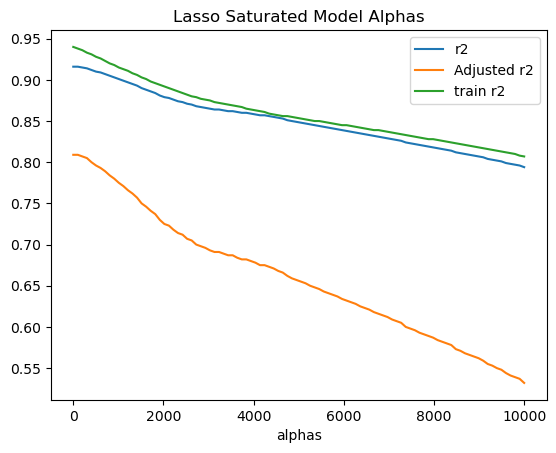

In [163]:
#LASSO, alpha tuning

alphas = np.linspace(0.1,10000.1,100)
results = []
coefs = []

for i in alphas:
    results.append(linear(housing_X, housing_y, log ='no', model = 'lasso',cont_trans = 'ss', alpha = i)[1])
    coefs.append(linear(housing_X, housing_y, log ='no', model = 'lasso',cont_trans = 'ss', alpha = i)[10])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Lasso Saturated Model Alphas', xlabel = 'alphas')

# Save the figure
fig = plt.gcf()
fig.savefig('images/Lasso_sat_alphas.png')

pd.DataFrame(results, index = alphas).reset_index().head(10)

In [164]:
coefs_df = pd.DataFrame(coefs, index = alphas, columns = X1.columns)
coefs_df.head(2)

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,remodeled_1,Nei_quant_2 - LowMed,Nei_quant_3 - MedHigh,Nei_quant_4 - High,Nei_quant_nan
0.100000,41668.894162,584.184876,5199.943706,8505.256230,6337.772562,11966.410656,1320.042691,4256.372528,13210.324194,4882.597933,...,0.0,389.160193,-1741.296963,1335.295896,4537.183502,-129.985482,3026.492122,-229.854958,-3808.067543,176.204624
101.110101,26486.072707,722.902273,4735.593204,9633.616276,5988.108446,10780.390369,1515.701061,4372.597753,9147.427592,3138.189467,...,0.0,-0.000000,-1847.046479,1182.744043,2217.494071,-34.555908,-963.900822,0.000000,8468.703581,280.145814


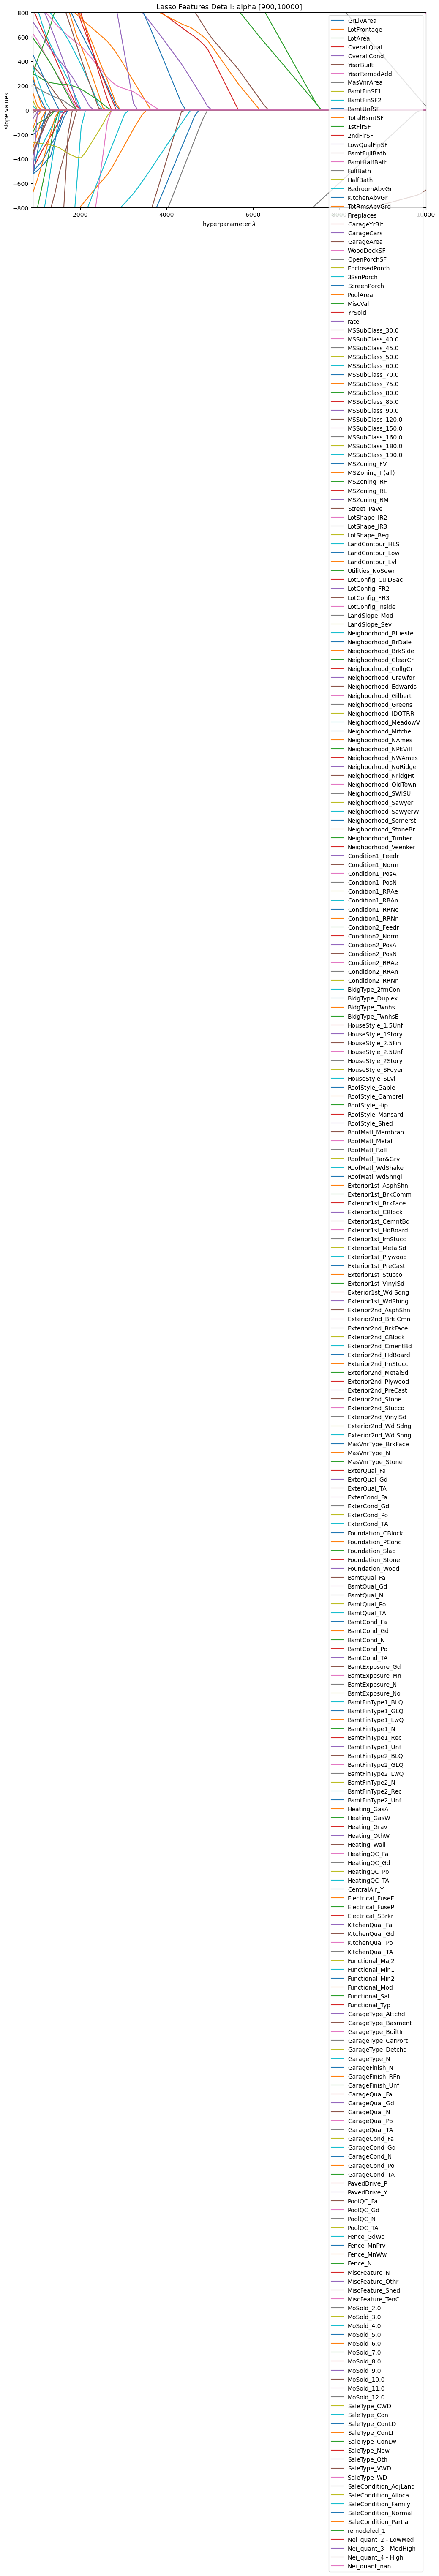

In [165]:
#SATURATE LASSO FEATURE PLOT
plt.figure(figsize=(12, 6)) 
for name in coefs_df.columns:
    plt.plot(coefs_df.index, coefs_df[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.title('Lasso Features Detail: alpha [900,10000]')
# plt.title('Lasso Features')
plt.xlim([900,10000])
plt.ylim([-800,800])
plt.legend(loc=1)   
plt.savefig('images/Lasso_fea_alphas_close.png')

In [166]:
#Lasso 1=Top 15 by way of feature selection at alpha = 10000.1
coefs_df.loc[10000.1,][coefs_df.loc[10000.1,] !=0]

#Many of the same features in the MLR

GrLivArea             19634.974457
OverallQual           23168.443189
YearBuilt              1838.071747
YearRemodAdd            788.690292
MasVnrArea               33.864043
BsmtFinSF1             5682.409908
TotalBsmtSF            6075.335040
1stFlrSF               2580.470360
GarageCars             1369.326492
GarageArea             4457.241254
ExterQual_TA           -656.915484
BsmtExposure_Gd        1350.722213
Nei_quant_4 - High     5166.326450
Name: 10000.1, dtype: float64

In [167]:
#LASSO WITH TOP 15 LASSO adj r2 = 87.1% compared to 80.9% from saturated model. 
lasso_coefs = coefs_df.loc[10000.1,][coefs_df.loc[10000.1,] !=0].reset_index().sort_values(by = 10000.1, ascending = False)['index']
lasso_coefs
split_linear(X1[lasso_coefs], np.log(y1['SalePrice']), cont_trans = 'ss', model = 'lasso', alpha = .00001)[1]

{'r2': 0.874,
 'Adjusted r2': 0.871,
 'train r2': 0.863,
 'MSE': 0.0,
 'Abs Error': 'skip',
 'RMSE': 0.0}

,alphas,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.000001,0.881000,0.878000,0.871000,0.019000,skip,0.138000
1,0.001011,0.880000,0.877000,0.871000,0.019000,skip,0.138000
2,0.002021,0.879000,0.876000,0.870000,0.019000,skip,0.138000
3,0.003031,0.879000,0.876000,0.869000,0.019000,skip,0.138000
4,0.004041,0.878000,0.875000,0.868000,0.019000,skip,0.138000
5,0.005051,0.877000,0.874000,0.868000,0.019000,skip,0.138000
6,0.006062,0.876000,0.873000,0.867000,0.019000,skip,0.138000
7,0.007072,0.875000,0.872000,0.866000,0.019000,skip,0.138000
8,0.008082,0.874000,0.871000,0.866000,0.020000,skip,0.141000
9,0.009092,0.872000,0.869000,0.865000,0.020000,skip,0.141000


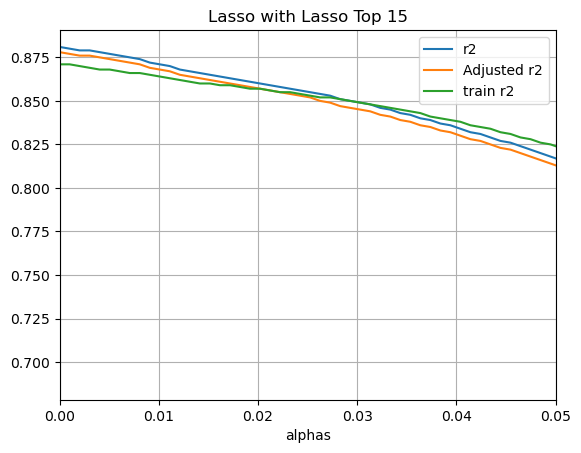

In [189]:
# Selected Features for Lasso 85.9% at alpha = .017

alphas = np.linspace(0.000001,.1,100)
alphas

results = []
coefs = []
for i in alphas:
    results.append(split_linear(X1[lasso_coefs], y1['SalePrice'], cont_trans = 'ss', model = 'lasso', alpha = i)[1])
    # coefs.append(split_linear(X1[lasso_coefs], np.log(y1['SalePrice']), cont_trans = 'ss', model = 'lasso', alpha = .00001)[10])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Lasso with Lasso Top 15', grid = True, xlabel = 'alphas',
                                                             xlim = [0,.05])
# Save the figure
fig = plt.gcf()
fig.savefig('images/Lasso_MLRtop15_alphas.png')

pd.DataFrame(results, index = alphas).reset_index().head(30).rename(columns = {'index':'alphas'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 17 else '' for i in x], axis=1)

Penalization is very little. Although r2 and adjusted r2 are lower than the saturated Lasso model, they converge. Adjusted stays closer to testing r2 for better stability. 

Train and adjusted r2 cross around alpha = .017173	for a no log model. Adj r2 is 85.9%.

,alphas,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.000001,0.881000,0.878000,0.871000,0.019000,skip,0.138000
1,0.001011,0.880000,0.877000,0.871000,0.019000,skip,0.138000
2,0.002021,0.879000,0.876000,0.870000,0.019000,skip,0.138000
3,0.003031,0.879000,0.876000,0.869000,0.019000,skip,0.138000
4,0.004041,0.878000,0.875000,0.868000,0.019000,skip,0.138000
5,0.005051,0.877000,0.874000,0.868000,0.019000,skip,0.138000
6,0.006062,0.876000,0.873000,0.867000,0.019000,skip,0.138000
7,0.007072,0.875000,0.872000,0.866000,0.019000,skip,0.138000
8,0.008082,0.874000,0.871000,0.866000,0.020000,skip,0.141000
9,0.009092,0.872000,0.869000,0.865000,0.020000,skip,0.141000


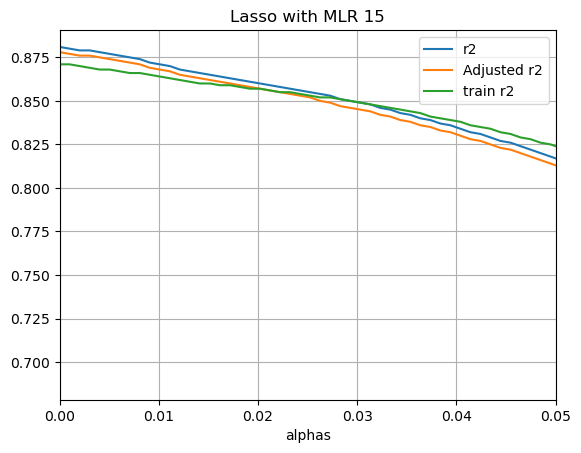

In [207]:
# LASSO with MLR TOP 15 FEATURES adj r2 = 84.7%

alphas = np.linspace(0.000001,.1,100)
alphas

results = []
coefs = []
for i in alphas:
    results.append(split_linear(X1[lasso_coefs], y1['SalePrice'], cont_trans = 'ss', model = 'lasso', alpha = i)[1])
    coefs.append(split_linear(X1[lasso_coefs], np.log(y1['SalePrice']), cont_trans = 'ss', model = 'lasso', alpha = .00001)[10])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Lasso with MLR 15', grid = True, xlabel = 'alphas',
                                                             xlim = [0,.05])
# Save the figure
fig = plt.gcf()
fig.savefig('images/Lasso_Lassotop15_alphas.png')

pd.DataFrame(results, index = alphas).reset_index().head(30).rename(columns = {'index':'alphas'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 28 else '' for i in x], axis=1)


In [170]:
#Feature engineer remodeled
X2 = X1.copy()
X2['remodeled'] = X2.YearBuilt - X2.YearRemodAdd
X2['remodeled'] = X2['remodeled'].apply(lambda x: 1 if x < 0 else 0)
X2 = X2.drop(columns = 'YearRemodAdd')
X2#.remodeled

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,remodeled_1,Nei_quant_2 - LowMed,Nei_quant_3 - MedHigh,Nei_quant_4 - High,Nei_quant_nan,remodeled
0,856,0,7890,6,6,1939,0,238,0,618,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,1049,42,4235,5,5,1984,149,552,393,104,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1001,60,6060,5,9,1930,0,737,0,100,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,1039,80,8146,4,8,1900,0,0,0,405,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1
4,1665,70,8400,8,6,2001,0,643,0,167,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,952,0,8854,6,6,1916,0,0,0,952,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2555,1733,0,13680,3,5,1955,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2556,2002,82,6270,5,6,1949,0,284,0,717,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2557,1842,0,8826,7,5,2000,144,841,0,144,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


,alphas,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.000001,0.873000,0.871000,0.862000,0.020000,skip,0.141000
1,0.001011,0.873000,0.871000,0.862000,0.020000,skip,0.141000
2,0.002021,0.872000,0.870000,0.862000,0.020000,skip,0.141000
3,0.003031,0.871000,0.869000,0.862000,0.020000,skip,0.141000
4,0.004041,0.870000,0.868000,0.861000,0.020000,skip,0.141000
5,0.005051,0.870000,0.868000,0.861000,0.020000,skip,0.141000
6,0.006062,0.868000,0.866000,0.861000,0.020000,skip,0.141000
7,0.007072,0.867000,0.865000,0.860000,0.021000,skip,0.145000
8,0.008082,0.866000,0.864000,0.860000,0.021000,skip,0.145000
9,0.009092,0.865000,0.863000,0.859000,0.021000,skip,0.145000


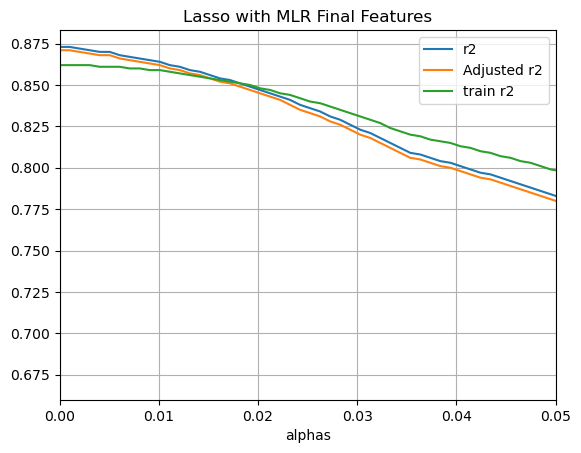

In [236]:
# LASSO with MLR FINAL FEATURES adj r2 85.6%

alphas = np.linspace(0.000001,.1,100)
alphas

results = []
coefs = []
for i in alphas:
    results.append(split_linear(X2[MLR_features], y1['SalePrice'], cont_trans = 'ss', model = 'lasso', alpha = i)[1])
    # coefs.append(split_linear(X1[lasso_coefs], np.log(y1['SalePrice']), cont_trans = 'ss', model = 'lasso', alpha = .00001)[10])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Lasso with MLR Final Features', grid = True, xlabel = 'alphas',
                                                             xlim = [0,.05])
# Save the figure
fig = plt.gcf()
fig.savefig('images/Lasso_MLRselect_alphas.png')

pd.DataFrame(results, index = alphas).reset_index().head(30).rename(columns = {'index':'alphas'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 13 else '' for i in x], axis=1)

MLR features perform better. 85.6% is where train cross adj r2. 

<p><a name="RIDGE"></a></p>

#### Ridge <a href="#con">[top]</a><br>

Similiar treatment to Ridge, but without feature selection.

In [32]:
#SATURATED RIDGE
linear_tests = ['No log, Norm','Log, Norm','Box, Norm','No log, SS', 'Log, SS','Box, SS']
pd.DataFrame([linear(housing_X, housing_y, log ='no', model = 'ridge', cont_trans = 'n')[1], linear(housing_X, housing_y, log ='yes', model = 'ridge',cont_trans = 'n', )[1],
              linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']], model = 'ridge',log ='no', cont_trans = 'n')[1],
             linear(housing_X, housing_y, log ='no', model = 'ridge',cont_trans = 'ss')[1],linear(housing_X, housing_y, log ='yes',model = 'ridge', cont_trans = 'ss')[1],
             linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']], model = 'ridge',log ='no', cont_trans = 'ss')[1]]
            , index = linear_tests).style.apply(
    lambda x: ['background-color: yellow' if x.name == 'Log, SS' else '' for i in x], axis=1)

,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
"No log, Norm",0.872000,0.709000,0.892000,817405895.182000,19277.825000,28590.311000
"Log, Norm",0.885000,0.739000,0.908000,0.018000,0.096000,0.134000
"Box, Norm",0.883000,0.734000,0.906000,0.006000,0.057000,0.077000
"No log, SS",0.917000,0.811000,0.940000,531629591.227000,14482.704000,23057.094000
"Log, SS",0.930000,0.841000,0.943000,0.011000,0.072000,0.105000
"Box, SS",0.928000,0.836000,0.941000,0.004000,0.043000,0.063000


,alphas,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.100000,0.930000,0.841000,0.943000,0.011000,0.072000,0.105000
1,101.110101,0.928000,0.836000,0.940000,0.011000,0.072000,0.105000
2,202.120202,0.926000,0.832000,0.938000,0.012000,0.073000,0.110000
3,303.130303,0.925000,0.830000,0.936000,0.012000,0.074000,0.110000
4,404.140404,0.923000,0.825000,0.935000,0.012000,0.075000,0.110000
5,505.150505,0.921000,0.821000,0.933000,0.012000,0.076000,0.110000
6,606.160606,0.920000,0.818000,0.931000,0.012000,0.076000,0.110000
7,707.170707,0.918000,0.814000,0.930000,0.013000,0.077000,0.114000
8,808.180808,0.917000,0.811000,0.928000,0.013000,0.078000,0.114000
9,909.190909,0.915000,0.807000,0.927000,0.013000,0.079000,0.114000


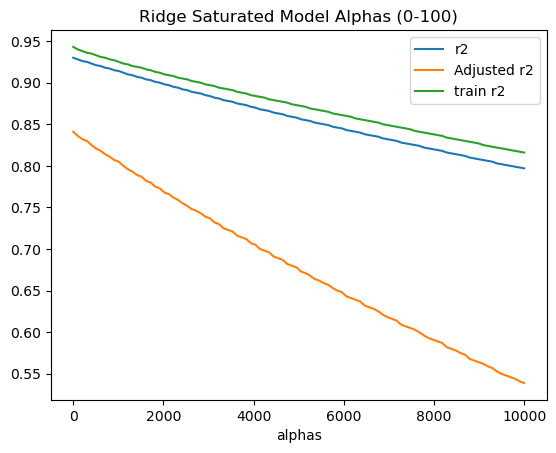

In [33]:
# RIDGE TUNING ALPHA No convergence, adj r2 is plumetting

alphas = np.linspace(0.1,10000.1,100)
alphas

results = []
for i in alphas:
    results.append(linear(housing_X, housing_y, log ='yes', model = 'ridge',cont_trans = 'ss', alpha = i)[1])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Ridge Saturated Model Alphas (0-100)',
                                                             xlabel = 'alphas')
# Save the figure
fig = plt.gcf()
fig.savefig('images/Ridge_Sat_alphas_100.png')

pd.DataFrame(results, index = alphas).reset_index().head(10).rename(columns = {'index':'alphas'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 0 else '' for i in x], axis=1)

,alphas,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.000001,0.881000,0.878000,0.871000,0.019000,skip,0.138000
1,50.505051,0.880000,0.877000,0.870000,0.019000,skip,0.138000
2,101.010102,0.879000,0.876000,0.870000,0.019000,skip,0.138000
3,151.515152,0.877000,0.874000,0.869000,0.019000,skip,0.138000
4,202.020203,0.876000,0.873000,0.867000,0.019000,skip,0.138000
5,252.525253,0.874000,0.871000,0.866000,0.020000,skip,0.141000
6,303.030304,0.873000,0.870000,0.865000,0.020000,skip,0.141000
7,353.535354,0.871000,0.868000,0.864000,0.020000,skip,0.141000
8,404.040405,0.870000,0.867000,0.863000,0.020000,skip,0.141000
9,454.545455,0.868000,0.865000,0.861000,0.021000,skip,0.145000


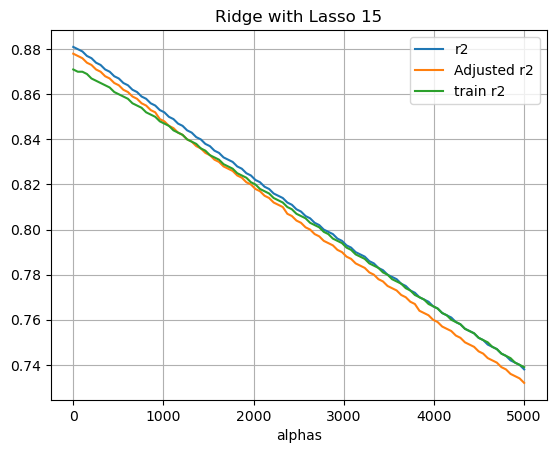

In [209]:
#RIDGE W LASSO 15 adj r2 = 79.2%
alphas = np.linspace(0.000001,5000,100)
alphas

results = []
coefs = []
for i in alphas:
    results.append(split_linear(X1[lasso_coefs], y1['SalePrice'], cont_trans = 'ss', model = 'ridge', alpha = i)[1])
    # coefs.append(split_linear(X1[lasso_coefs], np.log(y1['SalePrice']), cont_trans = 'ss', model = 'lasso', alpha = .00001)[10])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Ridge with Lasso 15', grid = True,
                                                             xlabel = 'alphas')

# Save the figure
fig = plt.gcf()
fig.savefig('images/Ridge_lasso15.png')

pd.DataFrame(results, index = alphas).reset_index().head(60).rename(columns = {'index':'alphas'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 59 else '' for i in x], axis=1)

Adjusted scores better than training, and all value are optimaized as alpha goes to xero. Therefore, best adj r2 is 85.2%.
Neither ridge or lasso with lasso features exceeds performance of MLR. 

,alphas,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.000001,0.897000,0.894000,0.885000,0.016000,skip,0.126000
1,50.505051,0.897000,0.894000,0.885000,0.016000,skip,0.126000
2,101.010102,0.896000,0.893000,0.884000,0.016000,skip,0.126000
3,151.515152,0.895000,0.892000,0.883000,0.016000,skip,0.126000
4,202.020203,0.893000,0.890000,0.882000,0.017000,skip,0.130000
5,252.525253,0.892000,0.889000,0.881000,0.017000,skip,0.130000
6,303.030304,0.891000,0.888000,0.880000,0.017000,skip,0.130000
7,353.535354,0.889000,0.886000,0.878000,0.017000,skip,0.130000
8,404.040405,0.888000,0.885000,0.877000,0.017000,skip,0.130000
9,454.545455,0.886000,0.883000,0.876000,0.018000,skip,0.134000


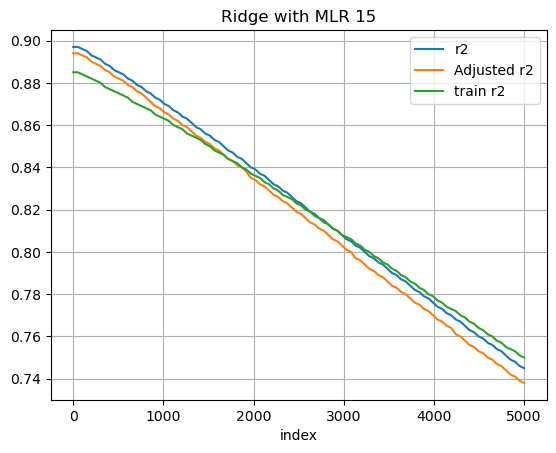

In [35]:
# RIDGE WITH MLR 15 adj r2 = 84.6%

alphas = np.linspace(0.000001,5000,100)
alphas

results = []
coefs = []
for i in alphas:
    results.append(split_linear(X1[top_15.Feature], y1['SalePrice'], cont_trans = 'ss', model = 'ridge', alpha = i)[1])
    # coefs.append(split_linear(X1[lasso_coefs], np.log(y1['SalePrice']), cont_trans = 'ss', model = 'lasso', alpha = .00001)[10])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Ridge with MLR 15', grid = True,
                                                             )
# Save the figure
fig = plt.gcf()
fig.savefig('images/Ridge_mlr15.png')

pd.DataFrame(results, index = alphas).reset_index().head(50).rename(columns = {'index':'alphas'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 33 else '' for i in x], axis=1)

,alphas,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
0,0.000001,0.876000,0.874000,0.867000,0.019000,skip,0.138000
1,50.505051,0.875000,0.873000,0.866000,0.019000,skip,0.138000
2,101.010102,0.873000,0.871000,0.865000,0.020000,skip,0.141000
3,151.515152,0.871000,0.869000,0.863000,0.020000,skip,0.141000
4,202.020203,0.869000,0.867000,0.861000,0.020000,skip,0.141000
5,252.525253,0.867000,0.865000,0.860000,0.021000,skip,0.145000
6,303.030304,0.864000,0.862000,0.858000,0.021000,skip,0.145000
7,353.535354,0.862000,0.860000,0.856000,0.022000,skip,0.148000
8,404.040405,0.859000,0.856000,0.854000,0.022000,skip,0.148000
9,454.545455,0.857000,0.854000,0.852000,0.022000,skip,0.148000


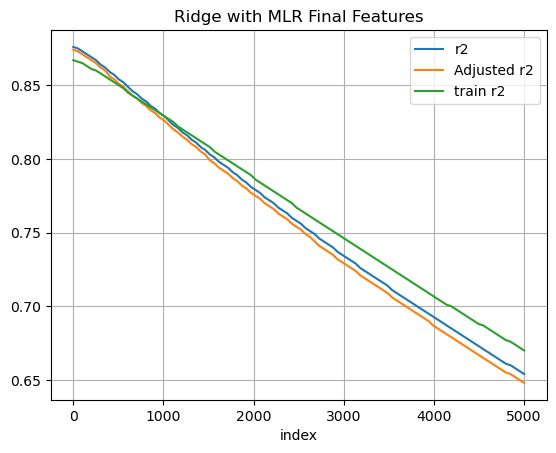

In [204]:
# RIDGE WITH MLR Final adj r2 = 85.0%

alphas = np.linspace(0.000001,5000,100)
alphas

results = []
coefs = []
for i in alphas:
    results.append(split_linear(X2[MLR_features], y1['SalePrice'], cont_trans = 'ss', model = 'ridge', alpha = i)[1])
    # coefs.append(split_linear(X1[lasso_coefs], np.log(y1['SalePrice']), cont_trans = 'ss', model = 'lasso', alpha = .00001)[10])

pd.DataFrame(results, index = alphas).reset_index().plot.line(x = 'index', y = ['r2','Adjusted r2', 'train r2'],
                                                             title = 'Ridge with MLR Final Features', grid = True,
                                                             )
# Save the figure
fig = plt.gcf()
fig.savefig('images/Ridge_mlr_final.png')

pd.DataFrame(results, index = alphas).reset_index().head(20).rename(columns = {'index':'alphas'}).style.apply(
    lambda x: ['background-color: yellow' if x.name == 19 else '' for i in x], axis=1)

Adj r2 and trani converge at 85.0%

<p><a name="ELASTIC"></a></p>

#### Elastic Net <a href="#con">[top]</a><br>

In [37]:
# ELASTIC NET SATURATED
linear_tests = ['No log, Norm','Log, Norm','Box, Norm','No log, SS', 'Log, SS','Box, SS']
pd.DataFrame([linear(housing_X, housing_y, log ='no', model = 'elastic', cont_trans = 'n')[1], linear(housing_X, housing_y, log ='yes', model = 'elastic',cont_trans = 'n', )[1],
              linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']], model = 'elastic',log ='no', cont_trans = 'n')[1],
             linear(housing_X, housing_y, log ='no', model = 'elastic',cont_trans = 'ss')[1],linear(housing_X, housing_y, log ='yes',model = 'elastic', cont_trans = 'ss')[1],
             linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']], model = 'elastic',log ='no', cont_trans = 'ss')[1]]
            , index = linear_tests).style.apply(
    lambda x: ['background-color: yellow' if x.name == 'No log, SS' else '' for i in x], axis=1)

,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
"No log, Norm",0.579000,0.044000,0.596000,2683118065.872000,34277.663000,51798.823000
"Log, Norm",-0.001000,-1.273000,0.000000,0.156000,0.302000,0.395000
"Box, Norm",-0.001000,-1.273000,0.000000,0.054000,0.177000,0.232000
"No log, SS",0.901000,0.775000,0.912000,632866502.610000,15417.025000,25156.838000
"Log, SS",-0.001000,-1.273000,0.000000,0.156000,0.302000,0.395000
"Box, SS",-0.001000,-1.273000,0.000000,0.054000,0.177000,0.232000


In [38]:
#GRID SEARCH SATURATED ELASTIC NET to find alpha and ratio. adj r2 = 83.9%

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet())
])

# Define the parameter grid
param_grid = {
    'elasticnet__alpha': np.logspace(-4, 4, 50),
    'elasticnet__l1_ratio': np.linspace(0, 1, 10)  # l1_ratio is the mix between L1 and L2 regularization
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation R^2 Score: {best_score}")

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_score}")

# Calculate the adjusted R^2 on the test set
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - test_score) * (n - 1) / (n - p - 1)
print(f"Adjusted R^2: {adjusted_r_squared}")


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.784e+00, tolerance: 2.340e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.431e+00, tolerance: 2.396e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

Best Parameters: {'elasticnet__alpha': 0.02811768697974228, 'elasticnet__l1_ratio': 0.1111111111111111}
Best Cross-Validation R^2 Score: 0.9087039084740052
Test R^2 Score: 0.9299395532167946
Adjusted R^2: 0.8401746057758126


In [39]:
#GRID SEARCH LASSO COEFS ELASTIC NET to find alpha and ratio. adj r2 = 88.5%

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1[lasso_coefs], y1, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet())
])

# Define the parameter grid
param_grid = {
    'elasticnet__alpha': np.logspace(-4, 4, 50),
    'elasticnet__l1_ratio': np.linspace(0, 1, 10)  # l1_ratio is the mix between L1 and L2 regularization
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation R^2 Score: {best_score}")

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_score}")

# Calculate the adjusted R^2 on the test set
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - test_score) * (n - 1) / (n - p - 1)
print(f"Adjusted R^2: {adjusted_r_squared}")


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e+01, tolerance: 2.340e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e+01, tolerance: 2.396e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

Best Parameters: {'elasticnet__alpha': 0.019306977288832496, 'elasticnet__l1_ratio': 0.0}
Best Cross-Validation R^2 Score: 0.866567577533744
Test R^2 Score: 0.8887747299920004
Adjusted R^2: 0.8858712590881771


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e+01, tolerance: 2.962e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [40]:
linear(housing_X, housing_y, log = 'yes', cont_trans = 'ss', model = 'elastic', alpha = 0.02811768697974228, 
       l1_ratio = 0.1111111111111111)[1]

{'r2': 0.923,
 'Adjusted r2': 0.825,
 'train r2': 0.93,
 'MSE': 0.012,
 'Abs Error': 0.076,
 'RMSE': 0.11}

Saturated Elastic still does not achieve the the r2 of MLR and has a large gap between train and adj test. 

In [41]:
#GRID SEARCH ELASTIC NET OF MLR FINAL FEATURES to find alpha and ratio. adj r2 = 87.2% (without GrLivArea, 81.4%)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2[MLR_features], y1, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet())
])

# Define the parameter grid
param_grid = {
    'elasticnet__alpha': np.logspace(-4, 4, 50),
    'elasticnet__l1_ratio': np.linspace(0, 1, 10)  # l1_ratio is the mix between L1 and L2 regularization
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation R^2 Score: {best_score}")

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_score}")

# Calculate the adjusted R^2 on the test set
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - test_score) * (n - 1) / (n - p - 1)
print(f"Adjusted R^2: {adjusted_r_squared}")


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e+01, tolerance: 2.340e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e+01, tolerance: 2.396e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

Best Parameters: {'elasticnet__alpha': 0.0006551285568595509, 'elasticnet__l1_ratio': 0.6666666666666666}
Best Cross-Validation R^2 Score: 0.8644554982209568
Test R^2 Score: 0.8749565782068414
Adjusted R^2: 0.8724607015243432


<p><a name="lassocv"></a></p>

### LassoCV

In [10]:
#SATURATED
linear_tests = ['No log, Norm','Log, Norm','Box, Norm','No log, SS', 'Log, SS','Box, SS']
pd.DataFrame([linear(housing_X, housing_y.values.ravel(), log ='no', model = 'lassocv', cont_trans = 'n')[1], linear(housing_X, housing_y.values.ravel(), log ='yes', model = 'lassocv',cont_trans = 'n', )[1],
              linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']].values.ravel(), model = 'lassocv',log ='no', cont_trans = 'n')[1],
             linear(housing_X, housing_y.values.ravel(), log ='no', model = 'lassocv',cont_trans = 'ss')[1],linear(housing_X, housing_y.values.ravel(), log ='yes',model = 'lassocv', cont_trans = 'ss')[1],
             linear(housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long','SalePrice_box']), housing_d[['SalePrice_box']].values.ravel(), model = 'lassocv',log ='no', cont_trans = 'ss')[1]]
            , index = linear_tests).style.apply(lambda x: ['background-color: yellow' if x.name == 'Log, SS' else '' for i in x], axis=1)


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.559e+09, tolerance: 1.107e+09
  model = cd_fast.enet_coordinate_descent(


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
"No log, Norm",0.875000,0.716000,0.894000,797325818.364000,78585.221000,28236.958000
"Log, Norm",0.892000,0.755000,0.908000,0.017000,0.417000,0.130000
"Box, Norm",0.889000,0.748000,0.906000,0.006000,0.245000,0.077000
"No log, SS",0.914000,0.805000,0.934000,549168471.293000,78912.157000,23434.344000
"Log, SS",0.923000,0.825000,0.931000,0.012000,0.418000,0.110000
"Box, SS",0.921000,0.821000,0.928000,0.004000,0.245000,0.063000


In [191]:
linear(housing_X, housing_y.values.ravel(), log ='yes',model = 'lassocv', cont_trans = 'ss')[11].alpha_

0.002908124823406814

In [192]:
[col for col in X1.columns if col.startswith('Nei_quant')]

['Nei_quant_2 - LowMed',
 'Nei_quant_3 - MedHigh',
 'Nei_quant_4 - High',
 'Nei_quant_nan']

In [193]:
len(linear(housing_X.drop(columns = 'Nei_quant'), housing_y.values.ravel(), log ='yes', model = 'lassocv',cont_trans = 'ss')[11].coef_)
t_list = X1.drop(columns = [col for col in X1.columns if col.startswith('Nei_quant')])
t_list

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,remodeled_1
0,856,0,7890,6,6,1939,1950,0,238,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1049,42,4235,5,5,1984,1984,149,552,393,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1001,60,6060,5,9,1930,2007,0,737,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1039,80,8146,4,8,1900,2003,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1665,70,8400,8,6,2001,2001,0,643,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,952,0,8854,6,6,1916,1950,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2555,1733,0,13680,3,5,1955,1955,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2556,2002,82,6270,5,6,1949,1950,0,284,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2557,1842,0,8826,7,5,2000,2000,144,841,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [197]:
#LassoCV Saturated Model 83.3%, select Top 15
print('alpha for sat model ' + str(linear(housing_X.drop(columns = 'Nei_quant'), housing_y.values.ravel(), log ='yes', model = 'lassocv',cont_trans = 'ss')[11].alpha_))
print(linear(housing_X.drop(columns = 'Nei_quant'), housing_y.values.ravel(), log ='yes', model = 'lassocv',cont_trans = 'ss')[1])
lascv_top_15 = pd.DataFrame(linear(housing_X.drop(columns = 'Nei_quant'), 
                                   housing_y.values.ravel(), log ='yes', model = 'lassocv',cont_trans = 'ss')[11].coef_,
            t_list.columns).sort_values(by = 0, ascending = False).head(15)
lascv_top_15

alpha for sat model 0.0020516245724028644
{'r2': 0.925, 'Adjusted r2': 0.833, 'train r2': 0.934, 'MSE': 0.012, 'Abs Error': 0.419, 'RMSE': 0.11}


,0
GrLivArea,0.125303
OverallQual,0.082722
YearBuilt,0.050022
OverallCond,0.043945
TotalBsmtSF,0.033148
BsmtFinSF1,0.028471
GarageCars,0.023510
Neighborhood_Somerst,0.021083
Neighborhood_Crawfor,0.019290
YearRemodAdd,0.018193


In [198]:
lascv_top_15.index

Index(['GrLivArea', 'OverallQual', 'YearBuilt', 'OverallCond', 'TotalBsmtSF',
       'BsmtFinSF1', 'GarageCars', 'Neighborhood_Somerst',
       'Neighborhood_Crawfor', 'YearRemodAdd', 'Fireplaces', 'LotArea',
       'SaleCondition_Normal', 'Neighborhood_NridgHt', 'MSZoning_RL'],
      dtype='object')

In [195]:
#LassoCV of top 15 features 'Adjusted r2': 90.7%,
print('alpha of top 15 model ' + str(split_linear(X1[lascv_top_15.index],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[11].alpha_)) # alpha = 0.00031182869256536844
split_linear(X1[lascv_top_15.index],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[1]

alpha of top 15 model 0.00031182869256536844


{'r2': 0.91,
 'Adjusted r2': 0.907,
 'train r2': 0.9,
 'MSE': 0.014,
 'Abs Error': 'skip',
 'RMSE': 0.118}

In [47]:
#Stripping features

lascv_top_15_trim = list(lascv_top_15.index)
remove = ['GrLivArea','TotalBsmtSF','BsmtFinSF1','LotArea',]
for i in remove:
    lascv_top_15_trim.remove(i)
print(lascv_top_15_trim)

#null, doesn't need any sq feet
split_linear(X1[lascv_top_15_trim],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[1]

results = []
for i in remove:
    results.append(split_linear(X1[(lascv_top_15_trim + [i])],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[1])
results.append(split_linear(X1[(lascv_top_15_trim)],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[1])
pd.DataFrame(results, index = remove+['null'])


['OverallQual', 'YearBuilt', 'OverallCond', 'GarageCars', 'Neighborhood_Somerst', 'Neighborhood_Crawfor', 'YearRemodAdd', 'Fireplaces', 'SaleCondition_Normal', 'Neighborhood_NridgHt', 'MSZoning_RL']


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
GrLivArea,0.876,0.873,0.867,0.019,skip,0.138
TotalBsmtSF,0.832,0.828,0.834,0.026,skip,0.161
BsmtFinSF1,0.822,0.818,0.821,0.028,skip,0.167
LotArea,0.811,0.807,0.818,0.029,skip,0.170
null,0.800,0.796,0.803,0.031,skip,0.176


In [201]:
#LassoCV with MLR Top 15 
pd.DataFrame([split_linear(X1[lascv_top_15.index],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[1],
              split_linear(X1[top_15.Feature],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[1],
              split_linear(X1[lasso_coefs],y1.values.ravel(), model = 'lassocv', cont_trans = 'ss')[1],
              split_linear(X2[MLR_features], y1.values.ravel(), cont_trans = 'ss', model = 'lassocv')[1]],
             index = ['Lassocv Top 15','MLR 15','Lasso Top 15 coef','MLR Easy Features']).style.apply(
    lambda x: ['background-color: yellow' if x.name == 'Lassocv Top 15' else '' for i in x], axis=1)

,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
Lassocv Top 15,0.910000,0.907000,0.900000,0.014000,skip,0.118000
MLR 15,0.897000,0.894000,0.885000,0.016000,skip,0.126000
Lasso Top 15 coef,0.881000,0.878000,0.871000,0.019000,skip,0.138000
MLR Easy Features,0.876000,0.874000,0.867000,0.019000,skip,0.138000


In [200]:
split_linear(X1[lascv_top_15.index],y1.values.ravel(), model = 'linear', cont_trans = 'ss')[1]

{'r2': 0.909,
 'Adjusted r2': 0.906,
 'train r2': 0.9,
 'MSE': 0.014,
 'Abs Error': 'skip',
 'RMSE': 0.118}

<p><a name="nei"></a></p>

#### Neighborhoods <a href="#top">[top]</a><br>

Adding a feature: Neighborhood Quantiles

Using LassoCV, has proven to be our strongest model, we run a saturated model and extract only the neighborhood coefficients. Sorting them, we can see how different Neighborhoods compare to each other. 

<Axes: title={'center': 'Neighborhood Coefficients of Sat Model'}, xlabel='Neighborhoods', ylabel='Log Coefficients'>

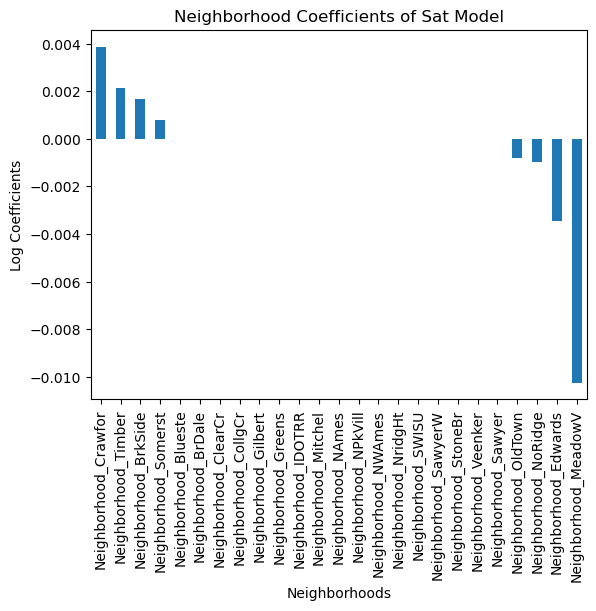

In [218]:
# Saturated LassoCV Model Neighborhood Coefs

pd.DataFrame(linear(housing_X, housing_y.values.ravel(), log ='yes', model = 'lassocv',cont_trans = 'ss')[11].coef_,
            X1.columns).sort_values(by = 0, ascending = False).reset_index()[pd.DataFrame(linear(housing_X, housing_y.values.ravel(), log ='yes', model = 'lassocv',cont_trans = 'ss')[11].coef_,
            X1.columns).sort_values(by = 0, ascending = False).reset_index()['index'].str.contains('Neighborhood')].plot.bar(
    x = 'index', y = 0, title = 'Neighborhood Coefficients of Sat Model', xlabel = 'Neighborhoods', ylabel = 'Log Coefficients', legend = False)


{'r2': 0.915, 'Adjusted r2': 0.909, 'train r2': 0.907, 'MSE': 0.013, 'Abs Error': 'skip', 'RMSE': 0.114}
intercept 11.89453215302618


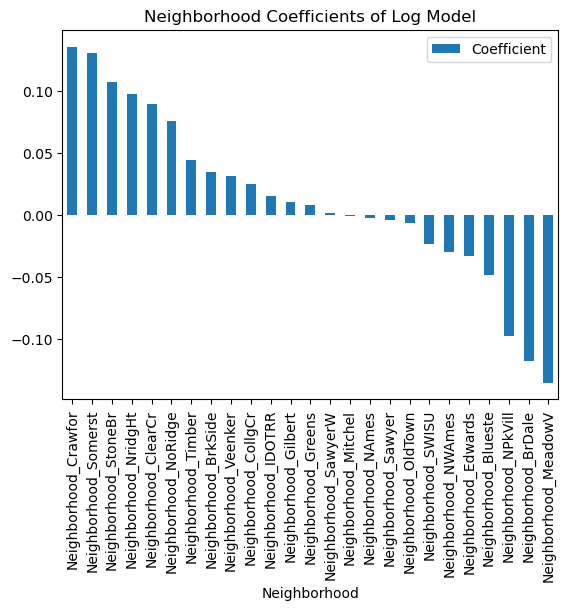

In [219]:
#Construct a list of Lasso top 15 and Neighborhoods. 

lassocv_neigh = list(lascv_top_15.index[~lascv_top_15.index.str.contains('Nei')])
lassocv_neigh.extend(list(X1.columns[X1.columns.str.contains('Neighborhood')]))

#Run a linear model on this sub group. 
print(split_linear(X1[lassocv_neigh], y1['SalePrice'], model = 'linear', cont_trans = 'ss')[1])
print('intercept ' + str(split_linear(X1[lassocv_neigh], y1['SalePrice'], model = 'linear', cont_trans = 'ss')[8]))
mlr_neigh_coef = split_linear(X1[lassocv_neigh], y1['SalePrice'], model = 'linear', cont_trans = 'ss')[2]
mlr_neigh_coef['Coef exp'] = np.exp(mlr_neigh_coef['Coefficient'])

#Plot the coefficients, sorted
mlr_neigh_coef[mlr_neigh_coef.Feature.str.contains('Nei')].reset_index().drop(columns = 'index').plot.bar(
    x = 'Feature', y = 'Coefficient', xlabel = 'Neighborhood', title = 'Neighborhood Coefficients of Log Model')

# Save the figure
fig = plt.gcf()
fig.savefig('images/MLR_neigh_log_only.png')

#Satisfied with score. Improved previous Linear Model Score of 87.4%

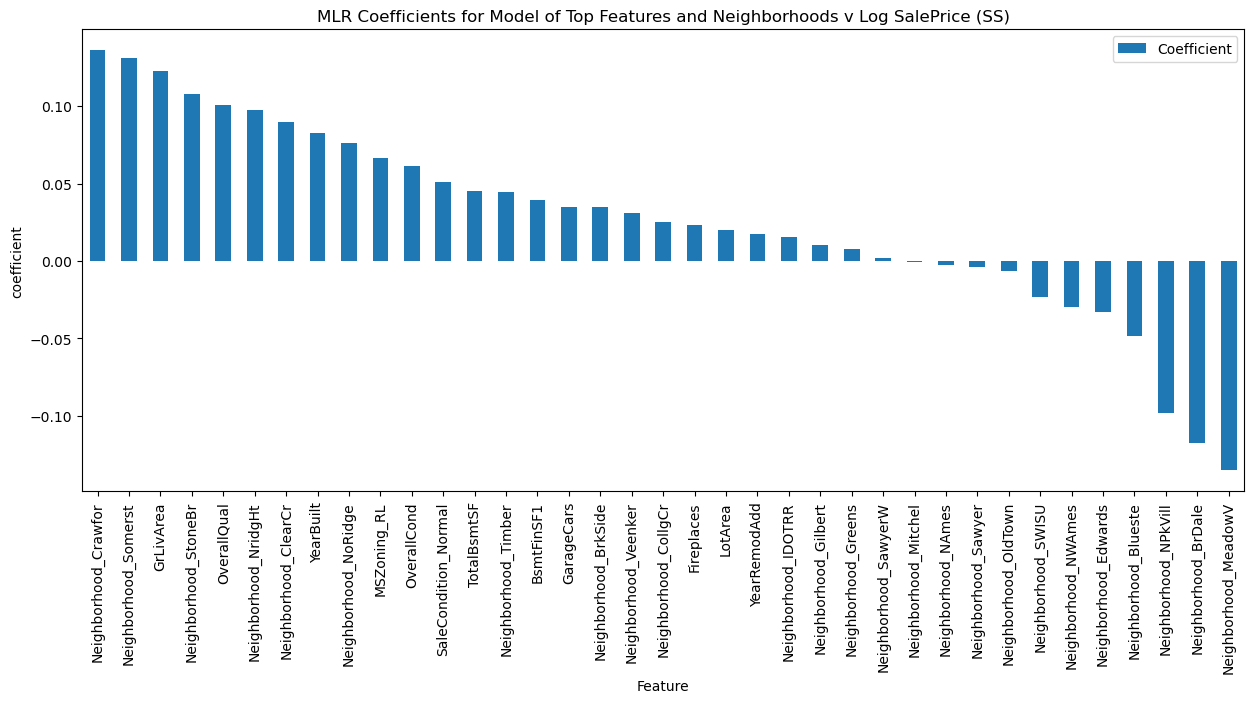

In [220]:
#Plotting all coefficients

mlr_neigh_coef.plot.bar(x = 'Feature', y = 'Coefficient', title = 'MLR Coefficients for Model of Top Features and Neighborhoods v Log SalePrice (SS)', ylabel = 'coefficient',
                       figsize = (15,6))
# Save the figure
fig = plt.gcf()
fig.savefig('images/MLR_neigh_log_ss.png')

# mlr_neigh_coef

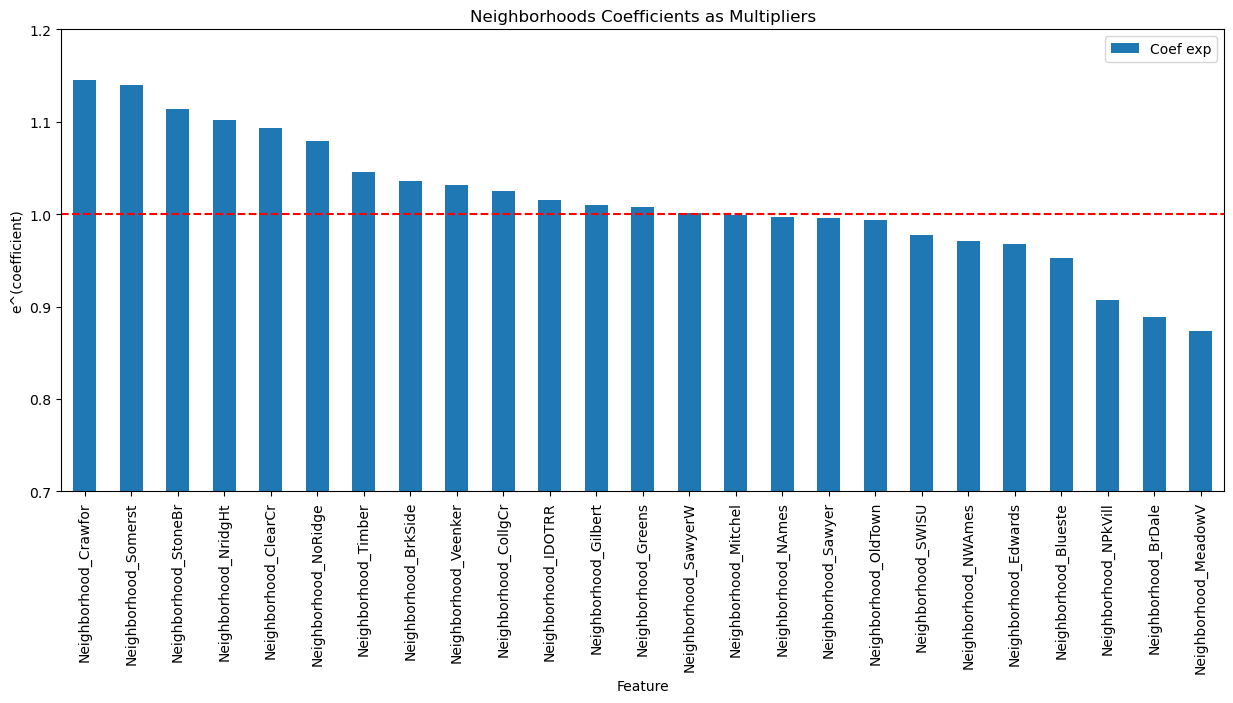

In [222]:
#Plotting np.exp(coef) for each neighborhood. Each value is a multiplier against a base house based (np.exp(intercept)). 

mlr_neigh_coef[mlr_neigh_coef.Feature.str.contains('Nei')].plot.bar(x = 'Feature', y = 'Coef exp', 
                    title = 'Neighborhoods Coefficients as Multipliers', ylabel = 'e^(coefficient)',
                       figsize = (15,6), ylim = [.7,1.2])
plt.axhline(y = 1, color = 'r', linestyle = '--')
# Save the figure
fig = plt.gcf()
fig.savefig('images/MLR_neigh_mul.png')


In [53]:
nei_quantiles = mlr_neigh_coef[mlr_neigh_coef.Feature.str.contains('Nei')]
nei_quantiles[['Coef exp']].describe()#.loc['25%','Coef exp']

,Coef exp
count,25.000000
mean,1.014844
std,0.070990
min,0.873434
25%,0.977227
50%,1.007961
75%,1.045505
max,1.145584


In [57]:
#Assigning quantile categories to all the nieghborhoods. reducing the number parameters. Facilitate better data analysis. 

nei_quantiles['quant'] = np.where(nei_quantiles['Coef exp'] <= nei_quantiles[['Coef exp']].describe().loc['25%','Coef exp'], '1 - Low',
                          np.where(nei_quantiles['Coef exp'] <= nei_quantiles[['Coef exp']].describe().loc['50%','Coef exp'], '2 - LowMed', 
                            np.where(nei_quantiles['Coef exp'] <= nei_quantiles[['Coef exp']].describe().loc['75%','Coef exp'], '3 - MedHigh', 
                                           '4 - High')))
#Saving file
nei_quantiles.to_pickle('nei_quant.pkl')


#Models.py will write this into the new DF under load_ames_nei()

/var/folders/xk/t8xh_8wx1pl_j7g1mtmxhnc40000gn/T/ipykernel_12785/2676228961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nei_quantiles['quant'] = np.where(nei_quantiles['Coef exp'] <= nei_quantiles[['Coef exp']].describe().loc['25%','Coef exp'], '1 - Low',


<p><a name="sum"></a></p>

#### Summary of Lasso Model, Coefs, Intercepts <a href="#top">[top]</a><br>

By using a transformed y, we are fitting a linear model to the natural log of the SalePrice. 

$$Y = \beta_0 +\beta_1\cdot features$$
$$Y = log(price)$$
$$log(price) = \beta_0 +\beta_1\cdot features$$
$$price = e^{\beta_0} \cdot e^{\beta_1*x_1}\cdot e^{\beta_2*x_2}\cdot e^{\beta_n*x_n}\cdot$$

$$price = e^{inter} \cdot e^{\beta_1*x_1}\cdot e^{\beta_2*x_2}\cdot e^{\beta_n*x_n}\cdot$$
$$price = \prod_{i=o}^{n} e^{\beta_i*x_i}$$


$$price = e^{11.89} \cdot e^{\beta_1*x_1}\cdot e^{\beta_2*x_2}\cdot e^{\beta_n*x_n}\cdot$$
$$e^{11.89} = base multiplier = $146,463$$

To add features to base price, multiply by $$e^{\beta_n*feature}$$
Negative features will yeild a multiplier of <1 and reduce the value. All feature values need to be scaled against the fitted model standard scaler (fitted with training data). 

In [55]:
#intercept of model as a multiplier

Base_Multiplier = np.exp(split_linear(X1[lassocv_neigh], y1['SalePrice'], model = 'linear', cont_trans = 'ss')[8])
Base_Multiplier
# split_linear(X1[lassocv_neigh], y1['SalePrice'], model = 'linear', cont_trans = 'ss')[8]

146463.59130344246

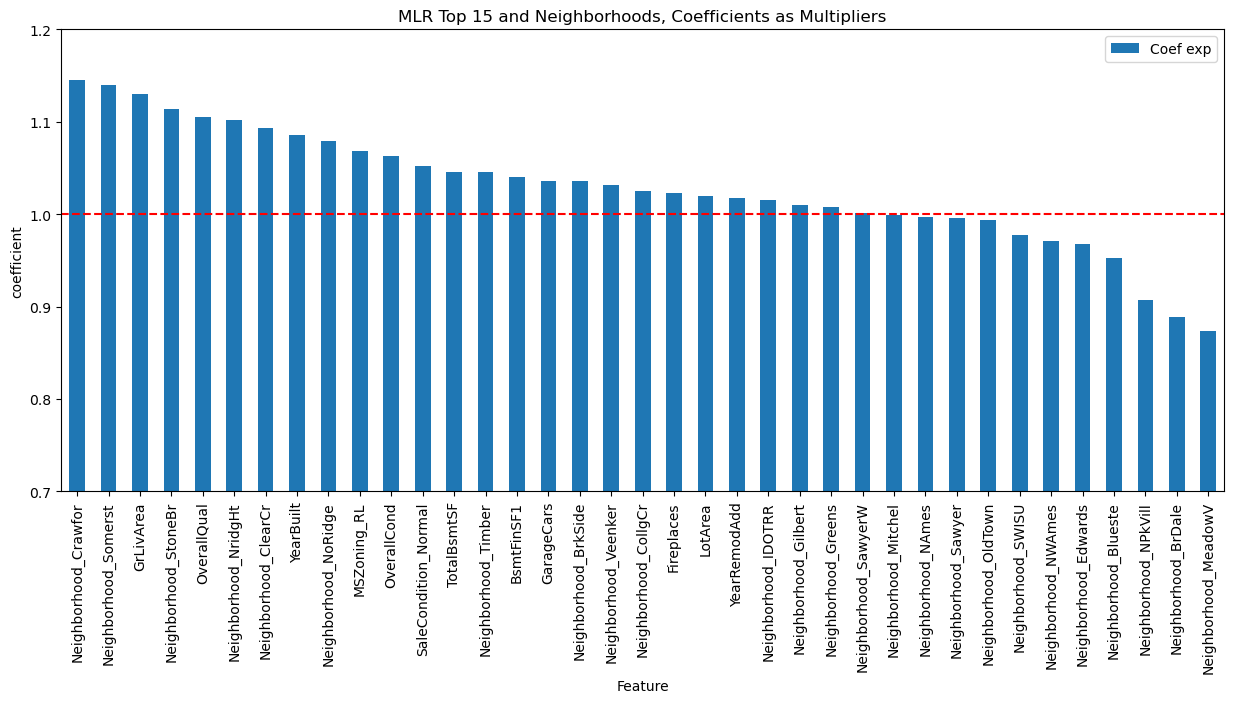

In [56]:
mlr_neigh_coef.plot.bar(x = 'Feature', y = 'Coef exp', title = 'MLR Top 15 and Neighborhoods, Coefficients as Multipliers', ylabel = 'coefficient',
                       figsize = (15,6), ylim = [.7,1.2])
plt.axhline(y = 1, color = 'r', linestyle = '--')